In [21]:
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

In [12]:
imgs = glob("static/imgs/*.jpg")

In [26]:
import numpy as np

def get_files(imgs, marked, n_targets=66, n_filler=22, n_vigilence=12):
    imgs_new = [img for img in imgs if img not in marked]
    files = np.random.choice(imgs_new, n_targets + n_filler + n_vigilence, replace=False)
    return files[:n_targets], files[n_targets: n_targets + n_filler], files[n_targets + n_filler: n_targets + n_filler + n_vigilence]

    
def next_vig(available, i, max_vigilence):
    l = []
    for j in range(i+1, len(available)):
        if available[j] - available[i] > 2:
            if available[j] - available[i] <= max_vigilence:
                l.append(j)
            else:
                break
    if len(l) == 0:
        return None
    return np.random.choice(l, 1)[0]

def next_target(labels, target, target_gap):
    temp_gap = 0; this_gap = 0
    while True:
        if labels[target + target_gap + temp_gap] == 0:
            this_gap = target_gap + temp_gap
            break
        if labels[target + target_gap - temp_gap] == 0:
            this_gap = target_gap - temp_gap
            break
        temp_gap += 1
    return this_gap

def set_target_reps(labels, files,file_targets, targets, target_gap):
    for i, target in enumerate(targets):  
        this_gap = next_target(labels, target, target_gap)
        labels[target+this_gap] = 2
        files[target+this_gap] = file_targets[i]

def get_sequence(file_targets, file_filler, file_vigilence, target_gap=80, max_vigilence=7):
    label_list = ["filler", "target", "target_rep", "vigilence", "vigilence_rep"]
    n_targets, n_filler, n_vigilence = len(file_targets), len(file_filler), len(file_vigilence)
    # shuffle
    np.random.shuffle(file_targets)
    np.random.shuffle(file_filler)
    np.random.shuffle(file_vigilence)
    n = n_targets*2 + n_filler + n_vigilence*2
    labels = np.zeros(n)
    files = np.array([file_targets[0]]*n)
    targets = np.random.choice(n-target_gap, n_targets, replace=False)
    labels[targets] = 1
    files[targets] = file_targets
    set_target_reps(labels, files,file_targets, targets, target_gap)
    available = np.array(range(n))[labels == 0]
    current_vigilence = 0
    for i in range(n_vigilence*2):
        s = np.random.choice(len(available), 1)[0]
        s_next = next_vig(available, s, max_vigilence)
        if s_next is None:
            continue
        labels[available[s]] = 3  
        files[available[s]] = file_vigilence[current_vigilence]
        labels[available[s_next]] = 4
        files[available[s_next]] = file_vigilence[current_vigilence]
        available = np.delete(available, s_next)
        available = np.delete(available, s)
        current_vigilence += 1
        if current_vigilence == n_vigilence:
            break

    files[available] = file_filler
    return files, labels

def evaluation(labels, answers):
    labels = np.array(labels)
    answers = np.array(answers)
    results = {}
    results["correct_filler"] = sum(answers[labels==0]==0)
    results["correct_target"] = sum(answers[labels==1]==0)
    results["correct_target_rep"] = sum(answers[labels==2]==1)
    results["correct_vigilence"] = sum(answers[labels==3]==0)
    results["correct_vigilence_rep"] = sum(answers[labels==4]==1)
    return results

def score(n_targets, n_filler, n_vigilence, labels, answers):
    e = evaluation(labels, answers)
    s_max = n_targets*3+n_filler+n_vigilence*2
    s = e["correct_filler"]+e["correct_target"]+2*e["correct_target_rep"]+e["correct_vigilence"]+e["correct_vigilence_rep"] 
    return round(np.sqrt(s)/np.sqrt(s_max)*100, 1)

def return_result(n_targets, n_filler, n_vigilence, labels, answers):
    e = evaluation(labels, answers)
    return("filler accuracy: {:.1f}%, target accuracy: {:.1f}%, vigilence accuracy: {:.1f}%".format(e['correct_filler']/n_filler*100, 
                                                                                               (e['correct_target']+e['correct_target_rep'])/(2*n_targets)*100, 
                                                                                               (e['correct_vigilence']+e['correct_vigilence_rep'])/(2*n_vigilence)*100))

In [27]:
def show(img_name, img_path="static/imgs"):
    image = Image.open(os.path.join(img_path, img_name))
    _, ax = plt.subplots(figsize=(4,4), dpi=120)
    ax.imshow(image)
    ax.set_yticks([])
    ax.set_xticks([])

In [42]:
n_targets, n_filler, n_vigilence = 66, 44, 12
file_targets, file_filler, file_vigilence = get_files(imgs, set(), n_targets=n_targets, n_filler=n_filler, n_vigilence=n_vigilence)
files, labels = get_sequence(file_targets, file_filler, file_vigilence)

In [43]:
labels

array([3., 3., 1., 0., 1., 4., 4., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 3., 3.,
       1., 1., 4., 3., 4., 1., 1., 1., 1., 1., 4., 0., 1., 0., 3., 0., 1.,
       4., 1., 3., 1., 1., 1., 4., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 3., 0., 1., 1., 4., 1., 1., 1., 0., 2., 1., 2., 1., 1.,
       1., 2., 2., 2., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 1.,
       2., 1., 2., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 2., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 0., 3., 0., 2., 0., 2., 4., 2., 2.,
       2., 0., 2., 2., 2., 2., 2., 0., 0., 2., 2., 0., 3., 2., 2., 0., 4.,
       2., 2., 0., 2., 2., 2., 0., 0., 2., 0., 2., 2., 2., 0., 0., 0., 2.,
       2., 2., 3., 2., 2., 4., 2., 2., 2., 2., 3., 2., 0., 2., 4., 0., 2.,
       2., 2., 0., 2., 2., 2., 2., 2., 2., 0., 0., 2., 2.])

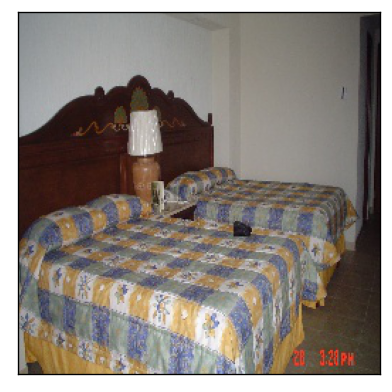

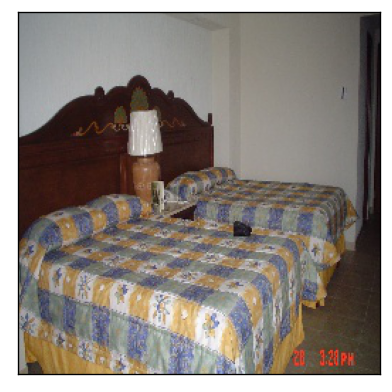

In [25]:
show(files[14], img_path="")
show(files[7], img_path="")

In [15]:
files

array(['static/imgs/sun_anzuvwufcueuxuqg.jpg',
       'static/imgs/sun_bduenszphooxbzxy.jpg',
       'static/imgs/sun_apftqswjkpinqcqd.jpg',
       'static/imgs/sun_akwjlbllmpspmwta.jpg',
       'static/imgs/sun_aakuaffhfasezvzq.jpg',
       'static/imgs/sun_bevahhrnhhgcszqb.jpg',
       'static/imgs/sun_aenyanwjhrycarxf.jpg',
       'static/imgs/sun_apyizpizpyruuyzy.jpg',
       'static/imgs/sun_aabvslkmdfpopcjk.jpg',
       'static/imgs/sun_bnermqodfamvctxr.jpg',
       'static/imgs/sun_anzsltscazyqwmfu.jpg',
       'static/imgs/sun_aolapnlyareobsux.jpg',
       'static/imgs/sun_aakuaffhfasezvzq.jpg',
       'static/imgs/sun_aatzxesqkyyjsxus.jpg',
       'static/imgs/sun_apyizpizpyruuyzy.jpg',
       'static/imgs/sun_anzlfonguargtiok.jpg',
       'static/imgs/sun_aolxzcseeqfnjnmy.jpg',
       'static/imgs/sun_ajaolagicteugdqr.jpg',
       'static/imgs/sun_aeonvombjjevkkdd.jpg',
       'static/imgs/sun_afismxrzgjotaqrf.jpg',
       'static/imgs/sun_ahppsanojkolapnh.jpg',
       'stati

In [12]:
answers = np.random.rand(len(labels))
answers[answers>0.5] = 1
answers[answers<=0.5] = 0

In [15]:
e = evaluation(labels, answers)

In [25]:
print_result(n_targets, n_filler, n_vigilence, labels, answers)

filler accuracy: 72.7%, target accuracy: 51.5%, vigilence accuracy: 20.8%


In [3]:
import pickle, os
import numpy as np
[evaluation, scores, marks] = pickle.load(open(os.path.join("data/ji", "data.pkl"), 'rb'))

In [4]:
evaluation

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [5]:
evaluation.append([1,2])

In [6]:
def valide_letter(s):
    if s.isalpha() or s.isdigit() or s == "_":
        return True
    return False

In [8]:
username = "ji_12"
''.join(filter(valide_letter, username.lower()))

'ji_12'

In [5]:
from src.dictionary_en import *
import numpy as np

def generate(max_length, number_length=2, items=['color', 'adjective', 'animal'], seperator='_'):
    count = 0
    while True:
        animal_rand = np.random.randint(0, len(animal)-1)
        adjective_rand = np.random.randint(0, len(adjective)-1)
        color_rand = np.random.randint(0, len(color)-1)
        item_value = []
        for item in items:
            seq = []
            if item == 'number':
                number = np.random.randint(pow(10, number_length-1), pow(10, number_length)-1)
                item_value.append(str(number))
            else:
                if item == 'adjective':
                    seq = adjective
                elif item == 'animal':
                    seq = animal
                elif item == 'color':
                    seq = color
                else:
                    item_value.append(str(item))
                    continue
                random_index = np.random.randint(0, len(seq)-1)
                item_value.append(seq[random_index])
        name = seperator.join(item_value)        
        if len(name) <= max_length:
            return name
        count = count + 1
        if count > 10000:
            raise ValueError('No available name found')

In [8]:
generate(max_length=18, number_length=0, items=['color', 'adjective', 'animal'])

'Sky_Blue_Right_cat'